In [26]:
import pandas as pd

df = pd.read_csv("dataset_19.csv")

In [27]:
import random

def replace_nan(row, col_name):
    if pd.isna(row[col_name]):
        return random.choice(df[col_name].dropna().tolist())
    return row[col_name]

df['tipo_hd'] = df.apply(replace_nan, col_name='tipo_hd', axis=1)
df['tipo_processador'] = df.apply(replace_nan, col_name='tipo_processador', axis=1)
df['armazenamento_tb'] = df.apply(replace_nan, col_name='armazenamento_tb', axis=1)


df = df.dropna()

In [28]:
# change armazenamento_tb to int: 0.256 is 1, 0.512 is 2, 1.0 is 4, 2.0 is 8
df['armazenamento_tb'] = df['armazenamento_tb'].replace({0.256: 1, 0.512: 2, 1.0: 4, 2.0: 8}).astype(int)
df['tipo_hd'] = df['tipo_hd'].replace({'SSD': 1, 'HDD': 0}).astype(int)

# todo mac usa apple sillicon
# se nao eh mac pode ser linux ou nao
# se nao eh mac pode ser amd ou nao
df['is_amd'] = df['tipo_processador'].apply(lambda x: 1 if 'AMD' in x else 0)
df['is_windows'] = df['sistema_operacional'].apply(lambda x: 1 if 'Windows' in x else 0)
df['is_mac'] = df['sistema_operacional'].apply(lambda x: 1 if 'MacOS' in x else 0)
df = df.drop(columns=['tipo_processador'])
df = df.drop(columns=['sistema_operacional'])

/tmp/ipykernel_337900/3217461436.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['tipo_hd'] = df['tipo_hd'].replace({'SSD': 1, 'HDD': 0}).astype(int)


In [29]:
df.head()

,cpu_cores,ram_gb,latencia_ms,armazenamento_tb,tipo_hd,tempo_resposta,is_amd,is_windows,is_mac
0,9,8,67.38,8,0,98.89,1,1,0
1,12,4,128.17,8,0,89.04,0,0,0
2,6,16,232.44,8,1,110.11,1,0,0
3,3,8,246.34,4,1,269.28,0,0,1
4,12,8,74.14,2,1,80.37,0,0,0


In [30]:
import statsmodels.api as sm

X = df.drop(columns=['tempo_resposta'])
X = sm.add_constant(X) # intercepto

y = df['tempo_resposta']

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     55.18
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.81e-43
Time:                        19:01:50   Log-Likelihood:                -893.12
No. Observations:                 180   AIC:                             1804.
Df Residuals:                     171   BIC:                             1833.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              251.8379     10.948  

In [47]:
# F test

model.f_pvalue

np.float64(8.125846370072553e-49)

In [31]:
t_stats = model.tvalues
p_values = model.pvalues

for param in X.columns:
    t_stat = t_stats[param]
    p_val  = p_values[param]
    decision = "REJECT H0" if p_val < 0.05 else "fail to reject H0"
    print(f"{param:>12} | t = {t_stat:6.3f} | p = {p_val:8.4f} → {decision}")

       const | t = 23.002 | p =   0.0000 → REJECT H0
   cpu_cores | t = -18.844 | p =   0.0000 → REJECT H0
      ram_gb | t = -9.923 | p =   0.0000 → REJECT H0
 latencia_ms | t = -1.004 | p =   0.3170 → fail to reject H0
armazenamento_tb | t =  0.200 | p =   0.8416 → fail to reject H0
     tipo_hd | t =  0.060 | p =   0.9523 → fail to reject H0
      is_amd | t = -0.570 | p =   0.5692 → fail to reject H0
  is_windows | t =  1.660 | p =   0.0987 → fail to reject H0
      is_mac | t =  0.392 | p =   0.6957 → fail to reject H0


In [32]:
ftest = "REJECT H0" if model.f_pvalue < 0.05 else "fail to reject H0"
print(f"F-test: {ftest} | p = {model.f_pvalue:.4f}")

F-test: REJECT H0 | p = 0.0000


In [33]:
# check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            feature        VIF
0             const  17.155436
1         cpu_cores   1.058913
2            ram_gb   1.031647
3       latencia_ms   1.037901
4  armazenamento_tb   1.036404
5           tipo_hd   1.044840
6            is_amd   1.319639
7        is_windows   1.271996
8            is_mac   1.391235


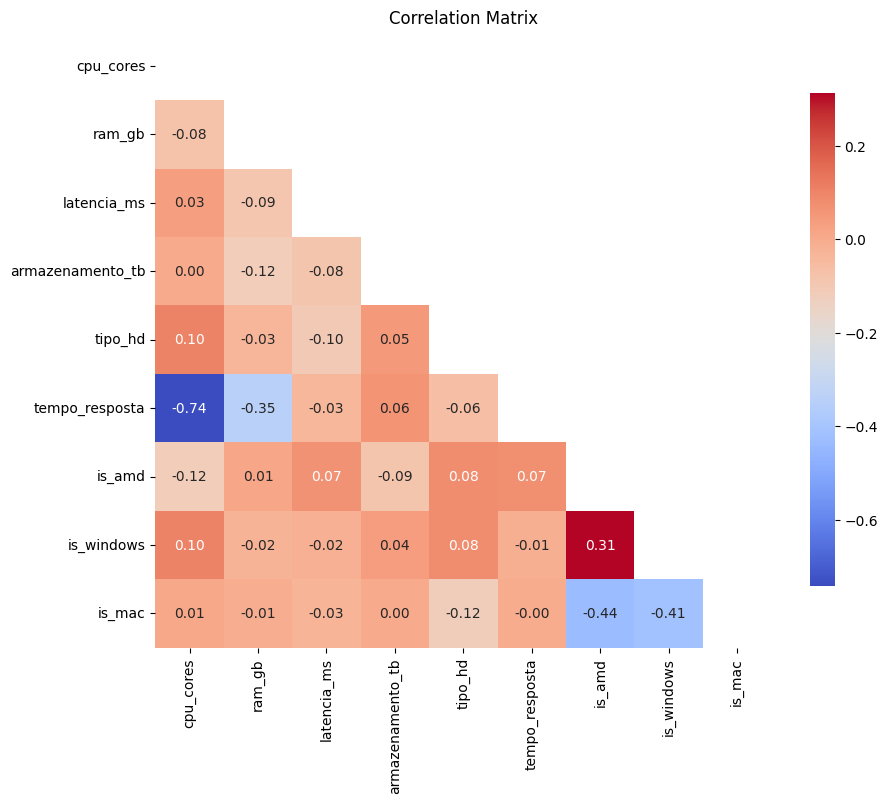

In [36]:
# correlation matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()


In [38]:
from statsmodels.stats.diagnostic import het_breuschpagan


bp_test = het_breuschpagan(model.resid, model.model.exog)
print("p value:", bp_test[1])

p value: 0.002118863077876762


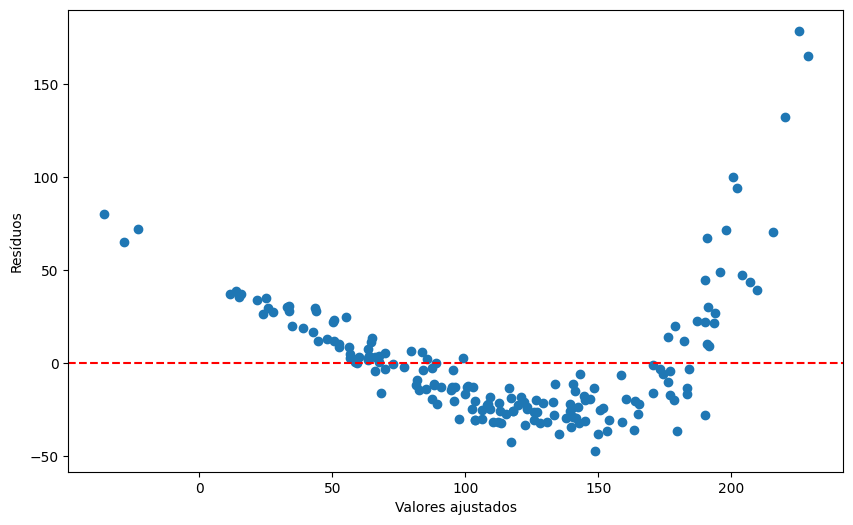

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Valores ajustados")
plt.ylabel("Resíduos")
plt.show()
